In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

celeb_data = pd.read_csv('../list_attr_celeba.csv')

# clean the data
celeb_data.replace(1, 1.0, inplace=True)
celeb_data.replace(-1, 0.0, inplace=True)
celeb_data.drop(columns=[
    'image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Bags_Under_Eyes', 
    'Bushy_Eyebrows', 'Bangs', 'Blurry', 'Smiling', 'Mouth_Slightly_Open', 
    'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 
    'Wearing_Necktie'
], inplace=True)

column_names = celeb_data.drop("Attractive", axis=1).columns
X = celeb_data.drop("Attractive", axis=1)
y = celeb_data["Attractive"]

In [56]:
# training and testing split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# training lasso (logistic regression with L1 regularization)
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=10.0)
lasso.fit(X_train_scaled, y_train)
coefficients = lasso.coef_[0]

selected_features = column_names[coefficients != 0]
print("Selected Features:")
for feature, coef in zip(selected_features, coefficients[coefficients != 0]):
    print(f"{feature}: {coef:.4f}")

# training BCELoss model
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# convert the data to pytorch tensors
# Convert the selected DataFrame to NumPy arrays before creating tensors
X_train_tensor = torch.tensor(X_train_selected.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_selected.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


# feedforward neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 32) # first layer (32 neurons)
        self.relu = nn.ReLU() # ReLU activation
        self.fc2 = nn.Linear(32, 16) # second layer (16 neurons)
        self.fc3 = nn.Linear(16, 1) # output layer
        self.sigmoid = nn.Sigmoid() # sigmoid func. for binary classification
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

Selected Features:
Bald: -0.1812
Big_Lips: -0.0051
Big_Nose: -0.1181
Black_Hair: 0.0504
Blond_Hair: 0.0741
Brown_Hair: 0.1317
Chubby: -0.4323
Double_Chin: -0.2020
Eyeglasses: -0.2884
Goatee: -0.0535
Gray_Hair: -0.2919
Heavy_Makeup: 0.6945
High_Cheekbones: 0.1662
Male: -0.0744
Mustache: -0.0425
Narrow_Eyes: -0.1317
No_Beard: -0.0715
Oval_Face: 0.2490
Pale_Skin: 0.1778
Pointy_Nose: 0.2642
Receding_Hairline: -0.2361
Rosy_Cheeks: 0.0640
Sideburns: 0.0850
Straight_Hair: 0.1739
Wavy_Hair: 0.1860
Young: 0.6541


In [57]:
# initialize model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.BCELoss() # using binary cross entropy loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # using adam optimizer

loss_values = []
# train model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())  # Save loss for plotting
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# evaluate model
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred = (y_pred_probs >= 0.5).float() # convert probabilities to binary

# need to convert to numpy to do sklearn metrics
y_pred_numpy = y_pred.squeeze().detach().numpy()
y_test_numpy = y_test_tensor.squeeze().detach().numpy()

Epoch [10/50], Loss: 0.6897
Epoch [20/50], Loss: 0.6790
Epoch [30/50], Loss: 0.6638
Epoch [40/50], Loss: 0.6427
Epoch [50/50], Loss: 0.6159


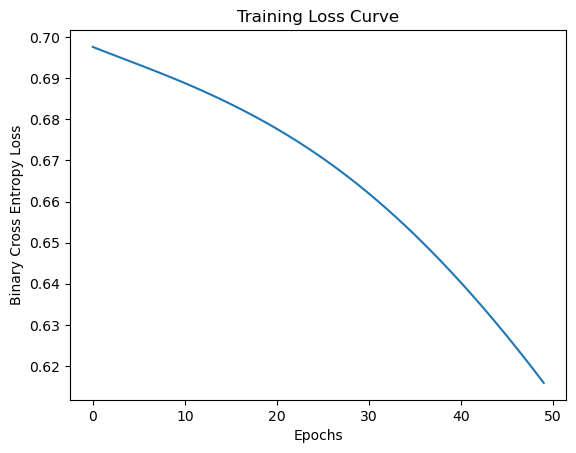

In [59]:
plt.plot(range(num_epochs), loss_values)
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.show()

In [61]:
# metrics
# accuracy
accuracy = accuracy_score(y_test_numpy, y_pred_numpy)
print(f"Accuracy: {accuracy:.6f}")
# precision
precision = precision_score(y_test_numpy, y_pred_numpy)
print(f"Precision: {precision:.6f}")
# recall
recall = recall_score(y_test_numpy, y_pred_numpy)
print(f"Recall: {recall:.6f}")
# F1 score
f1 = f1_score(y_test_numpy, y_pred_numpy)
print(f"F1 Score: {f1:.6f}")

Accuracy: 0.690721
Precision: 0.640833
Recall: 0.897571
F1 Score: 0.747779
